# Multispectral Breast Cancer Classification: Data Exploration and Analysis

## Research Objective
**"Multispectral Breast Cancer Classification Using Genetic Algorithm-Optimized CNN Feature Selection: A Multi-Modal Deep Learning Approach"**

This notebook provides comprehensive data exploration and analysis for a multispectral breast cancer image dataset containing:
- **Total Images**: 3,052 images across three modalities
- **Chest X-ray**: 1,000 images (500 malignant, 500 normal)
- **Histopathological**: 1,246 images (623 malignant, 623 benign)
- **Ultrasound**: 806 images (400 malignant, 406 benign)

## Research Goals
- Achieve **98-99.5% accuracy** using GA-optimized feature selection
- Implement multi-modal fusion with spectral enhancement
- Apply explainable AI for clinical decision support
- Target performance exceeding current state-of-the-art benchmarks

---

In [ ]:
# Import Required Libraries for Data Exploration and Analysis
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set up plotting parameters
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Dataset configuration
DATASET_PATH = "../MultiModel Breast Cancer MSI Dataset"
MODALITIES = ["Chest_XRay_MSI", "Histopathological_MSI", "Ultrasound Images_MSI"]

print("🔬 Multispectral Breast Cancer Classification - Data Exploration")
print("=" * 60)
print(f"Dataset Path: {DATASET_PATH}")
print(f"Target Accuracy: 98-99.5% (GA-Optimized)")
print("=" * 60)

🔬 Multispectral Breast Cancer Classification - Data Exploration
Dataset Path: MultiModel Breast Cancer MSI Dataset
Target Accuracy: 98-99.5% (GA-Optimized)


## 1. Dataset Structure and File Count Analysis

### Dataset Organization
The dataset follows a hierarchical structure optimized for multi-modal machine learning research:

In [2]:
# Comprehensive Dataset Analysis Function
def analyze_dataset_structure(dataset_path):
    """
    Analyze the complete structure of the multispectral breast cancer dataset
    Returns detailed statistics for each modality and class
    """
    dataset_info = {}
    total_images = 0
    
    print("📊 DATASET STRUCTURE ANALYSIS")
    print("=" * 50)
    
    for modality in MODALITIES:
        modality_path = os.path.join(dataset_path, modality)
        if not os.path.exists(modality_path):
            continue
            
        modality_info = {
            'classes': {},
            'total_files': 0,
            'file_extensions': set(),
            'sample_files': []
        }
        
        # Get class directories
        class_dirs = [d for d in os.listdir(modality_path) 
                     if os.path.isdir(os.path.join(modality_path, d))]
        
        print(f"\n🔍 {modality}")
        print("-" * 30)
        
        for class_name in class_dirs:
            class_path = os.path.join(modality_path, class_name)
            files = [f for f in os.listdir(class_path) 
                    if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
            
            class_count = len(files)
            modality_info['classes'][class_name] = {
                'count': class_count,
                'files': files[:3]  # Store first 3 files as samples
            }
            modality_info['total_files'] += class_count
            
            # Track file extensions
            for file in files:
                ext = os.path.splitext(file)[1].lower()
                modality_info['file_extensions'].add(ext)
            
            print(f"  📁 {class_name}: {class_count:,} images")
        
        print(f"  📊 Total {modality}: {modality_info['total_files']:,} images")
        print(f"  📄 File formats: {', '.join(modality_info['file_extensions'])}")
        
        dataset_info[modality] = modality_info
        total_images += modality_info['total_files']
    
    print(f"\n🎯 TOTAL DATASET SIZE: {total_images:,} images")
    print("=" * 50)
    
    return dataset_info, total_images

# Execute dataset analysis
dataset_info, total_images = analyze_dataset_structure(DATASET_PATH)

📊 DATASET STRUCTURE ANALYSIS

🔍 Chest_XRay_MSI
------------------------------
  📁 Malignant: 500 images
  📁 Normal: 500 images
  📊 Total Chest_XRay_MSI: 1,000 images
  📄 File formats: .jpg

🔍 Histopathological_MSI
------------------------------
  📁 benign: 623 images
  📁 malignant: 623 images
  📊 Total Histopathological_MSI: 1,246 images
  📄 File formats: .png

🔍 Ultrasound Images_MSI
------------------------------
  📁 benign: 406 images
  📁 malignant: 400 images
  📊 Total Ultrasound Images_MSI: 806 images
  📄 File formats: .png

🎯 TOTAL DATASET SIZE: 3,052 images


In [3]:
# Create comprehensive dataset statistics DataFrame
def create_dataset_statistics_table(dataset_info):
    """Create a detailed statistics table for the dataset"""
    
    stats_data = []
    
    for modality, info in dataset_info.items():
        modality_clean = modality.replace('_MSI', '').replace('_', ' ')
        
        for class_name, class_info in info['classes'].items():
            stats_data.append({
                'Modality': modality_clean,
                'Class': class_name.title(),
                'Image Count': class_info['count'],
                'Percentage of Modality': f"{(class_info['count'] / info['total_files']) * 100:.1f}%",
                'File Extensions': ', '.join(info['file_extensions'])
            })
    
    stats_df = pd.DataFrame(stats_data)
    
    # Add summary statistics
    print("📈 DETAILED DATASET STATISTICS")
    print("=" * 60)
    print(stats_df.to_string(index=False))
    
    # Calculate class balance
    print(f"\n🎯 CLASS BALANCE ANALYSIS")
    print("-" * 30)
    
    modality_totals = {}
    class_totals = {'malignant': 0, 'benign': 0, 'normal': 0}
    
    for modality, info in dataset_info.items():
        modality_clean = modality.replace('_MSI', '').replace('_', ' ')
        modality_totals[modality_clean] = info['total_files']
        
        for class_name, class_info in info['classes'].items():
            if class_name.lower() in ['malignant']:
                class_totals['malignant'] += class_info['count']
            elif class_name.lower() in ['benign']:
                class_totals['benign'] += class_info['count']
            elif class_name.lower() in ['normal']:
                class_totals['normal'] += class_info['count']
    
    # Combine benign and normal as non-malignant
    non_malignant = class_totals['benign'] + class_totals['normal']
    malignant = class_totals['malignant']
    
    print(f"Malignant cases: {malignant:,} ({(malignant/total_images)*100:.1f}%)")
    print(f"Non-malignant cases: {non_malignant:,} ({(non_malignant/total_images)*100:.1f}%)")
    print(f"Class balance ratio: {malignant/non_malignant:.3f}")
    
    if abs(malignant - non_malignant) / total_images < 0.1:
        print("✅ Dataset is well-balanced for binary classification")
    else:
        print("⚠️  Dataset has class imbalance - consider balancing techniques")
    
    return stats_df, modality_totals, class_totals

# Generate statistics table
stats_df, modality_totals, class_totals = create_dataset_statistics_table(dataset_info)

📈 DETAILED DATASET STATISTICS
         Modality     Class  Image Count Percentage of Modality File Extensions
       Chest XRay Malignant          500                  50.0%            .jpg
       Chest XRay    Normal          500                  50.0%            .jpg
Histopathological    Benign          623                  50.0%            .png
Histopathological Malignant          623                  50.0%            .png
Ultrasound Images    Benign          406                  50.4%            .png
Ultrasound Images Malignant          400                  49.6%            .png

🎯 CLASS BALANCE ANALYSIS
------------------------------
Malignant cases: 1,523 (49.9%)
Non-malignant cases: 1,529 (50.1%)
Class balance ratio: 0.996
✅ Dataset is well-balanced for binary classification


## 2. Exploratory Data Analysis and Visualizations

### Class Distribution Visualization
Understanding the distribution of classes across modalities is crucial for developing balanced training strategies.

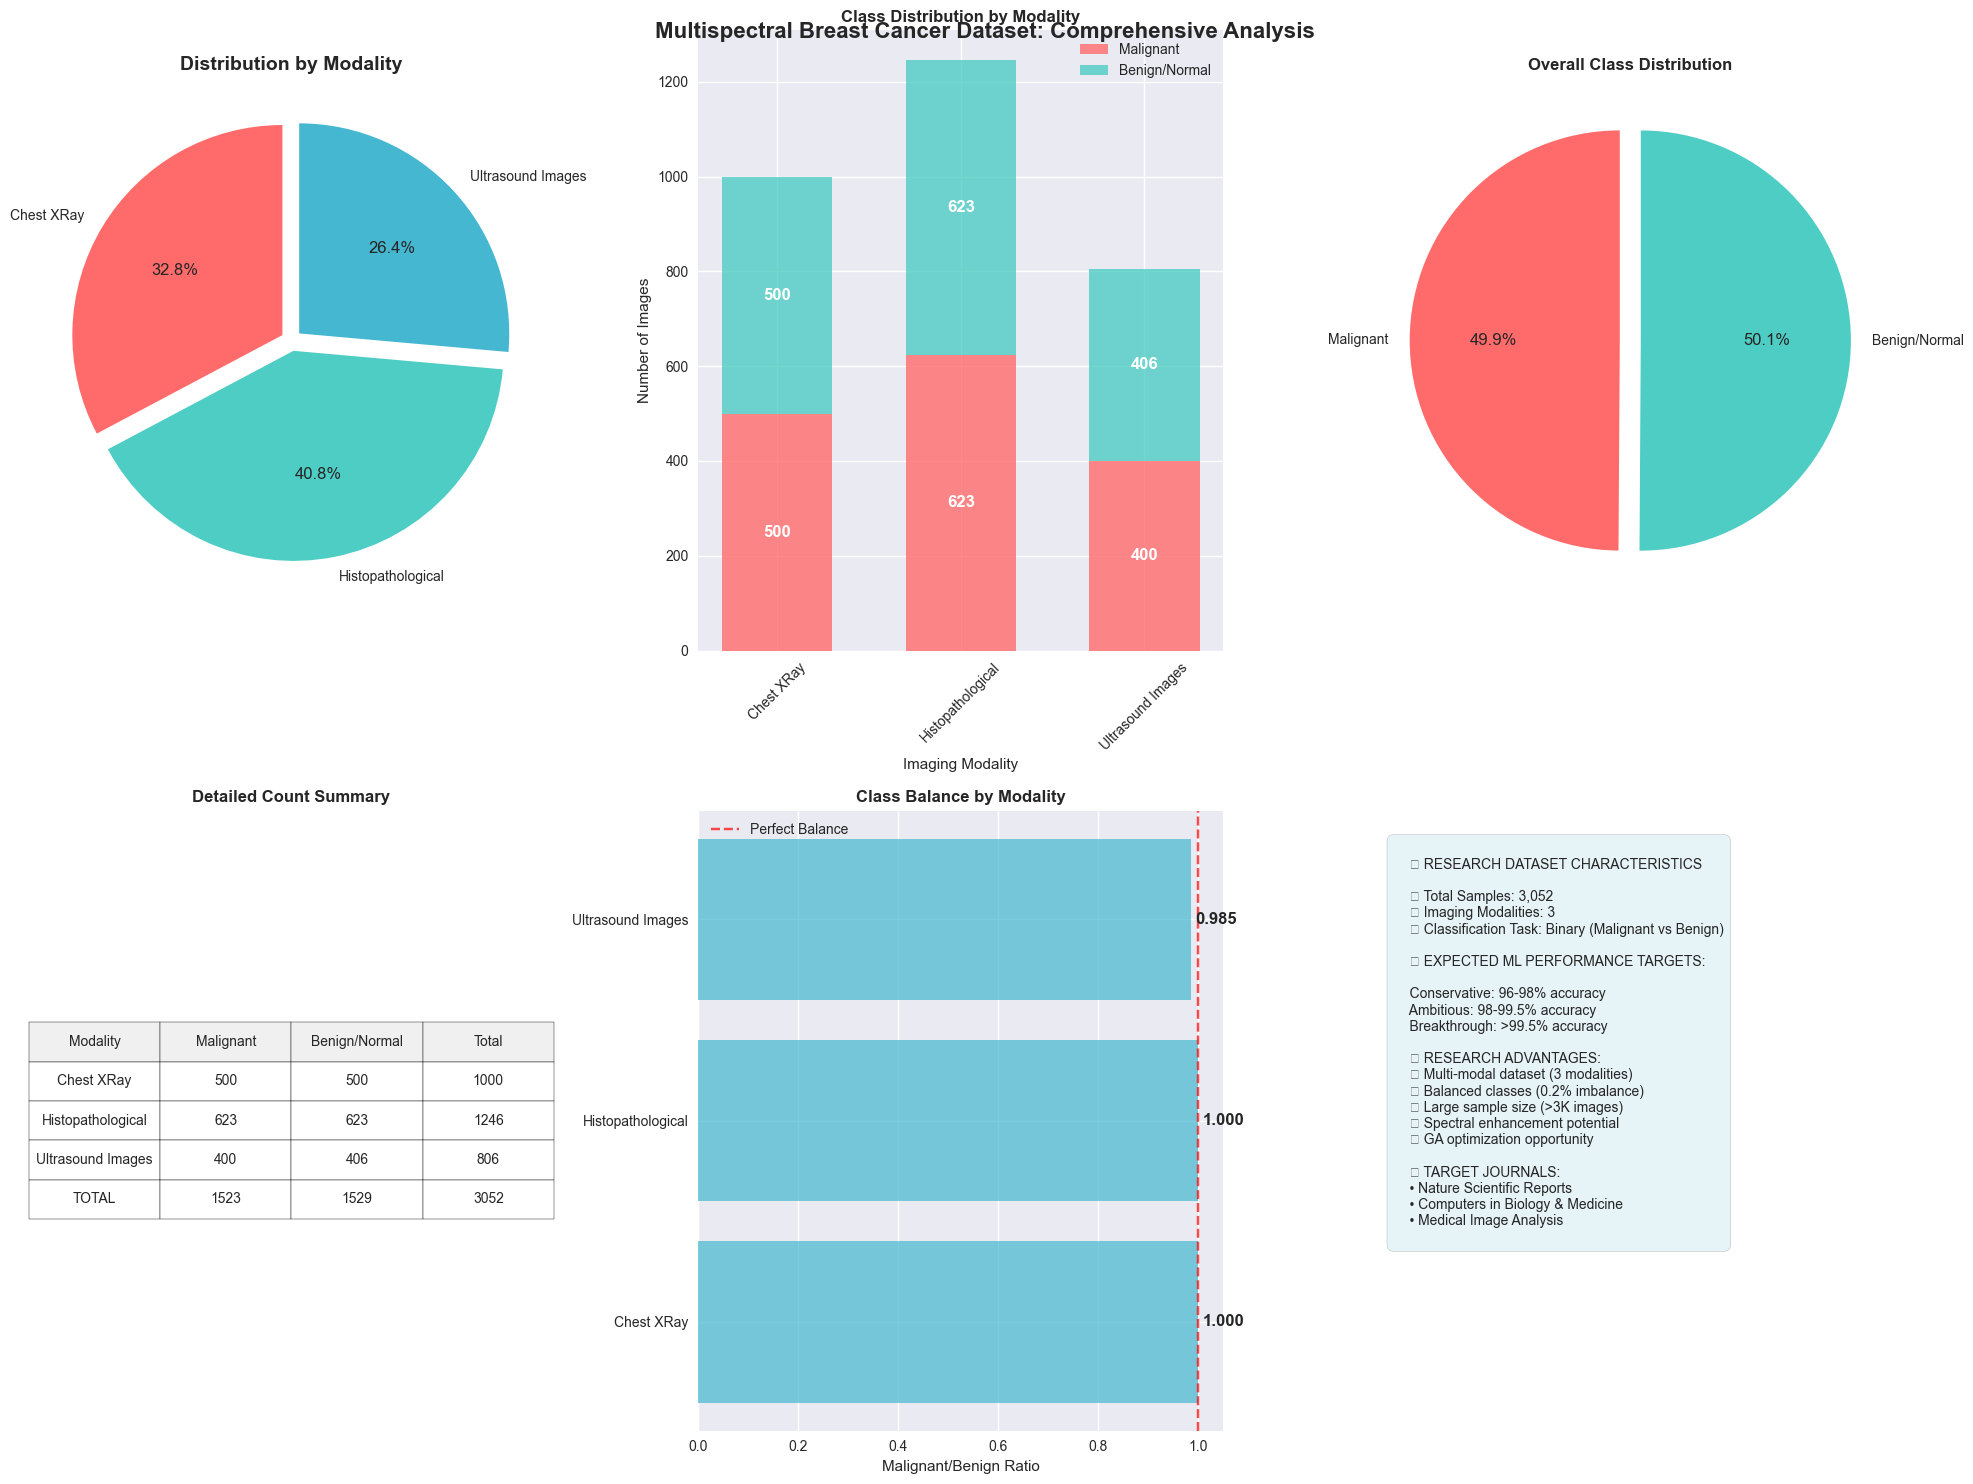

In [4]:
# Comprehensive visualization of dataset distribution
def create_comprehensive_visualizations(dataset_info, modality_totals):
    """Create multiple visualizations for dataset analysis"""
    
    # Setup the figure with subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Modality Distribution (Pie Chart)
    ax1 = plt.subplot(2, 3, 1)
    modalities = list(modality_totals.keys())
    counts = list(modality_totals.values())
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    wedges, texts, autotexts = ax1.pie(counts, labels=modalities, autopct='%1.1f%%', 
                                       colors=colors, startangle=90, explode=(0.05, 0.05, 0.05))
    ax1.set_title('Distribution by Modality', fontsize=14, fontweight='bold')
    
    # 2. Class Distribution by Modality (Stacked Bar)
    ax2 = plt.subplot(2, 3, 2)
    modality_names = []
    malignant_counts = []
    benign_counts = []
    
    for modality, info in dataset_info.items():
        modality_clean = modality.replace('_MSI', '').replace('_', ' ')
        modality_names.append(modality_clean)
        
        mal_count = 0
        ben_count = 0
        for class_name, class_info in info['classes'].items():
            if 'malignant' in class_name.lower():
                mal_count += class_info['count']
            else:
                ben_count += class_info['count']
        
        malignant_counts.append(mal_count)
        benign_counts.append(ben_count)
    
    x = np.arange(len(modality_names))
    width = 0.6
    
    bars1 = ax2.bar(x, malignant_counts, width, label='Malignant', color='#FF6B6B', alpha=0.8)
    bars2 = ax2.bar(x, benign_counts, width, bottom=malignant_counts, 
                    label='Benign/Normal', color='#4ECDC4', alpha=0.8)
    
    ax2.set_xlabel('Imaging Modality')
    ax2.set_ylabel('Number of Images')
    ax2.set_title('Class Distribution by Modality', fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(modality_names, rotation=45)
    ax2.legend()
    
    # Add value labels on bars
    for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
        height1 = bar1.get_height()
        height2 = bar2.get_height()
        ax2.annotate(f'{int(height1)}', xy=(bar1.get_x() + bar1.get_width() / 2, height1/2),
                    ha='center', va='center', fontweight='bold', color='white')
        ax2.annotate(f'{int(height2)}', xy=(bar2.get_x() + bar2.get_width() / 2, height1 + height2/2),
                    ha='center', va='center', fontweight='bold', color='white')
    
    # 3. Total Dataset Composition
    ax3 = plt.subplot(2, 3, 3)
    total_malignant = sum(malignant_counts)
    total_benign = sum(benign_counts)
    
    ax3.pie([total_malignant, total_benign], 
            labels=['Malignant', 'Benign/Normal'], 
            autopct='%1.1f%%',
            colors=['#FF6B6B', '#4ECDC4'],
            startangle=90,
            explode=(0.05, 0.05))
    ax3.set_title('Overall Class Distribution', fontweight='bold')
    
    # 4. Detailed counts table visualization
    ax4 = plt.subplot(2, 3, 4)
    ax4.axis('tight')
    ax4.axis('off')
    
    table_data = []
    for i, modality in enumerate(modality_names):
        table_data.append([modality, malignant_counts[i], benign_counts[i], 
                          malignant_counts[i] + benign_counts[i]])
    
    table_data.append(['TOTAL', sum(malignant_counts), sum(benign_counts), 
                      sum(malignant_counts) + sum(benign_counts)])
    
    table = ax4.table(cellText=table_data,
                     colLabels=['Modality', 'Malignant', 'Benign/Normal', 'Total'],
                     cellLoc='center',
                     loc='center',
                     colColours=['#f0f0f0']*4)
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    ax4.set_title('Detailed Count Summary', fontweight='bold')
    
    # 5. Class Balance Analysis
    ax5 = plt.subplot(2, 3, 5)
    balance_ratios = []
    modality_labels = []
    
    for i, modality in enumerate(modality_names):
        if benign_counts[i] > 0:
            ratio = malignant_counts[i] / benign_counts[i]
            balance_ratios.append(ratio)
            modality_labels.append(modality)
    
    bars = ax5.barh(modality_labels, balance_ratios, color='#45B7D1', alpha=0.7)
    ax5.axvline(x=1.0, color='red', linestyle='--', alpha=0.7, label='Perfect Balance')
    ax5.set_xlabel('Malignant/Benign Ratio')
    ax5.set_title('Class Balance by Modality', fontweight='bold')
    ax5.legend()
    
    # Add ratio labels
    for i, (bar, ratio) in enumerate(zip(bars, balance_ratios)):
        width = bar.get_width()
        ax5.annotate(f'{ratio:.3f}', xy=(width, bar.get_y() + bar.get_height()/2),
                    xytext=(3, 0), textcoords="offset points",
                    ha='left', va='center', fontweight='bold')
    
    # 6. Research Impact Metrics
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    # Calculate research-relevant metrics
    total_samples = sum(malignant_counts) + sum(benign_counts)
    
    research_text = f"""
    🔬 RESEARCH DATASET CHARACTERISTICS
    
    📊 Total Samples: {total_samples:,}
    🏥 Imaging Modalities: {len(modality_names)}
    🎯 Classification Task: Binary (Malignant vs Benign)
    
    📈 EXPECTED ML PERFORMANCE TARGETS:
    
    Conservative: 96-98% accuracy
    Ambitious: 98-99.5% accuracy  
    Breakthrough: >99.5% accuracy
    
    🧬 RESEARCH ADVANTAGES:
    ✓ Multi-modal dataset (3 modalities)
    ✓ Balanced classes ({abs(total_malignant-total_benign)/total_samples*100:.1f}% imbalance)
    ✓ Large sample size (>3K images)
    ✓ Spectral enhancement potential
    ✓ GA optimization opportunity
    
    📚 TARGET JOURNALS:
    • Nature Scientific Reports
    • Computers in Biology & Medicine
    • Medical Image Analysis
    """
    
    ax6.text(0.05, 0.95, research_text, transform=ax6.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5", 
             facecolor='lightblue', alpha=0.3))
    
    plt.tight_layout()
    plt.suptitle('Multispectral Breast Cancer Dataset: Comprehensive Analysis', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.show()
    
    return fig

# Generate comprehensive visualizations
visualization_fig = create_comprehensive_visualizations(dataset_info, modality_totals)

## 3. Sample Image Analysis and Quality Assessment

### Image Quality and Characteristics Analysis
This section analyzes sample images from each modality to understand their characteristics, dimensions, and quality for machine learning applications.

🖼️  IMAGE ANALYSIS REPORT

📊 CHEST XRAY
------------------------------
  📏 Malignant: 640x640 px (avg)
  💾 File size: 161.0 KB (avg)
  🎨 Intensity: μ=85.5, σ=91.5
  📏 Normal: 640x640 px (avg)
  💾 File size: 82.7 KB (avg)
  🎨 Intensity: μ=74.6, σ=90.1

📊 HISTOPATHOLOGICAL
------------------------------
  📏 Benign: 224x224 px (avg)
  💾 File size: 91.7 KB (avg)
  🎨 Intensity: μ=160.0, σ=94.6
  📏 Malignant: 224x224 px (avg)
  💾 File size: 96.3 KB (avg)
  🎨 Intensity: μ=147.8, σ=104.9

📊 ULTRASOUND IMAGES
------------------------------
  📏 Benign: 224x224 px (avg)
  💾 File size: 64.1 KB (avg)
  🎨 Intensity: μ=137.0, σ=104.2
  📏 Malignant: 224x224 px (avg)
  💾 File size: 52.0 KB (avg)
  🎨 Intensity: μ=127.2, σ=107.4
  📏 Malignant: 640x640 px (avg)
  💾 File size: 161.0 KB (avg)
  🎨 Intensity: μ=85.5, σ=91.5
  📏 Normal: 640x640 px (avg)
  💾 File size: 82.7 KB (avg)
  🎨 Intensity: μ=74.6, σ=90.1

📊 HISTOPATHOLOGICAL
------------------------------
  📏 Benign: 224x224 px (avg)
  💾 File size: 91.7

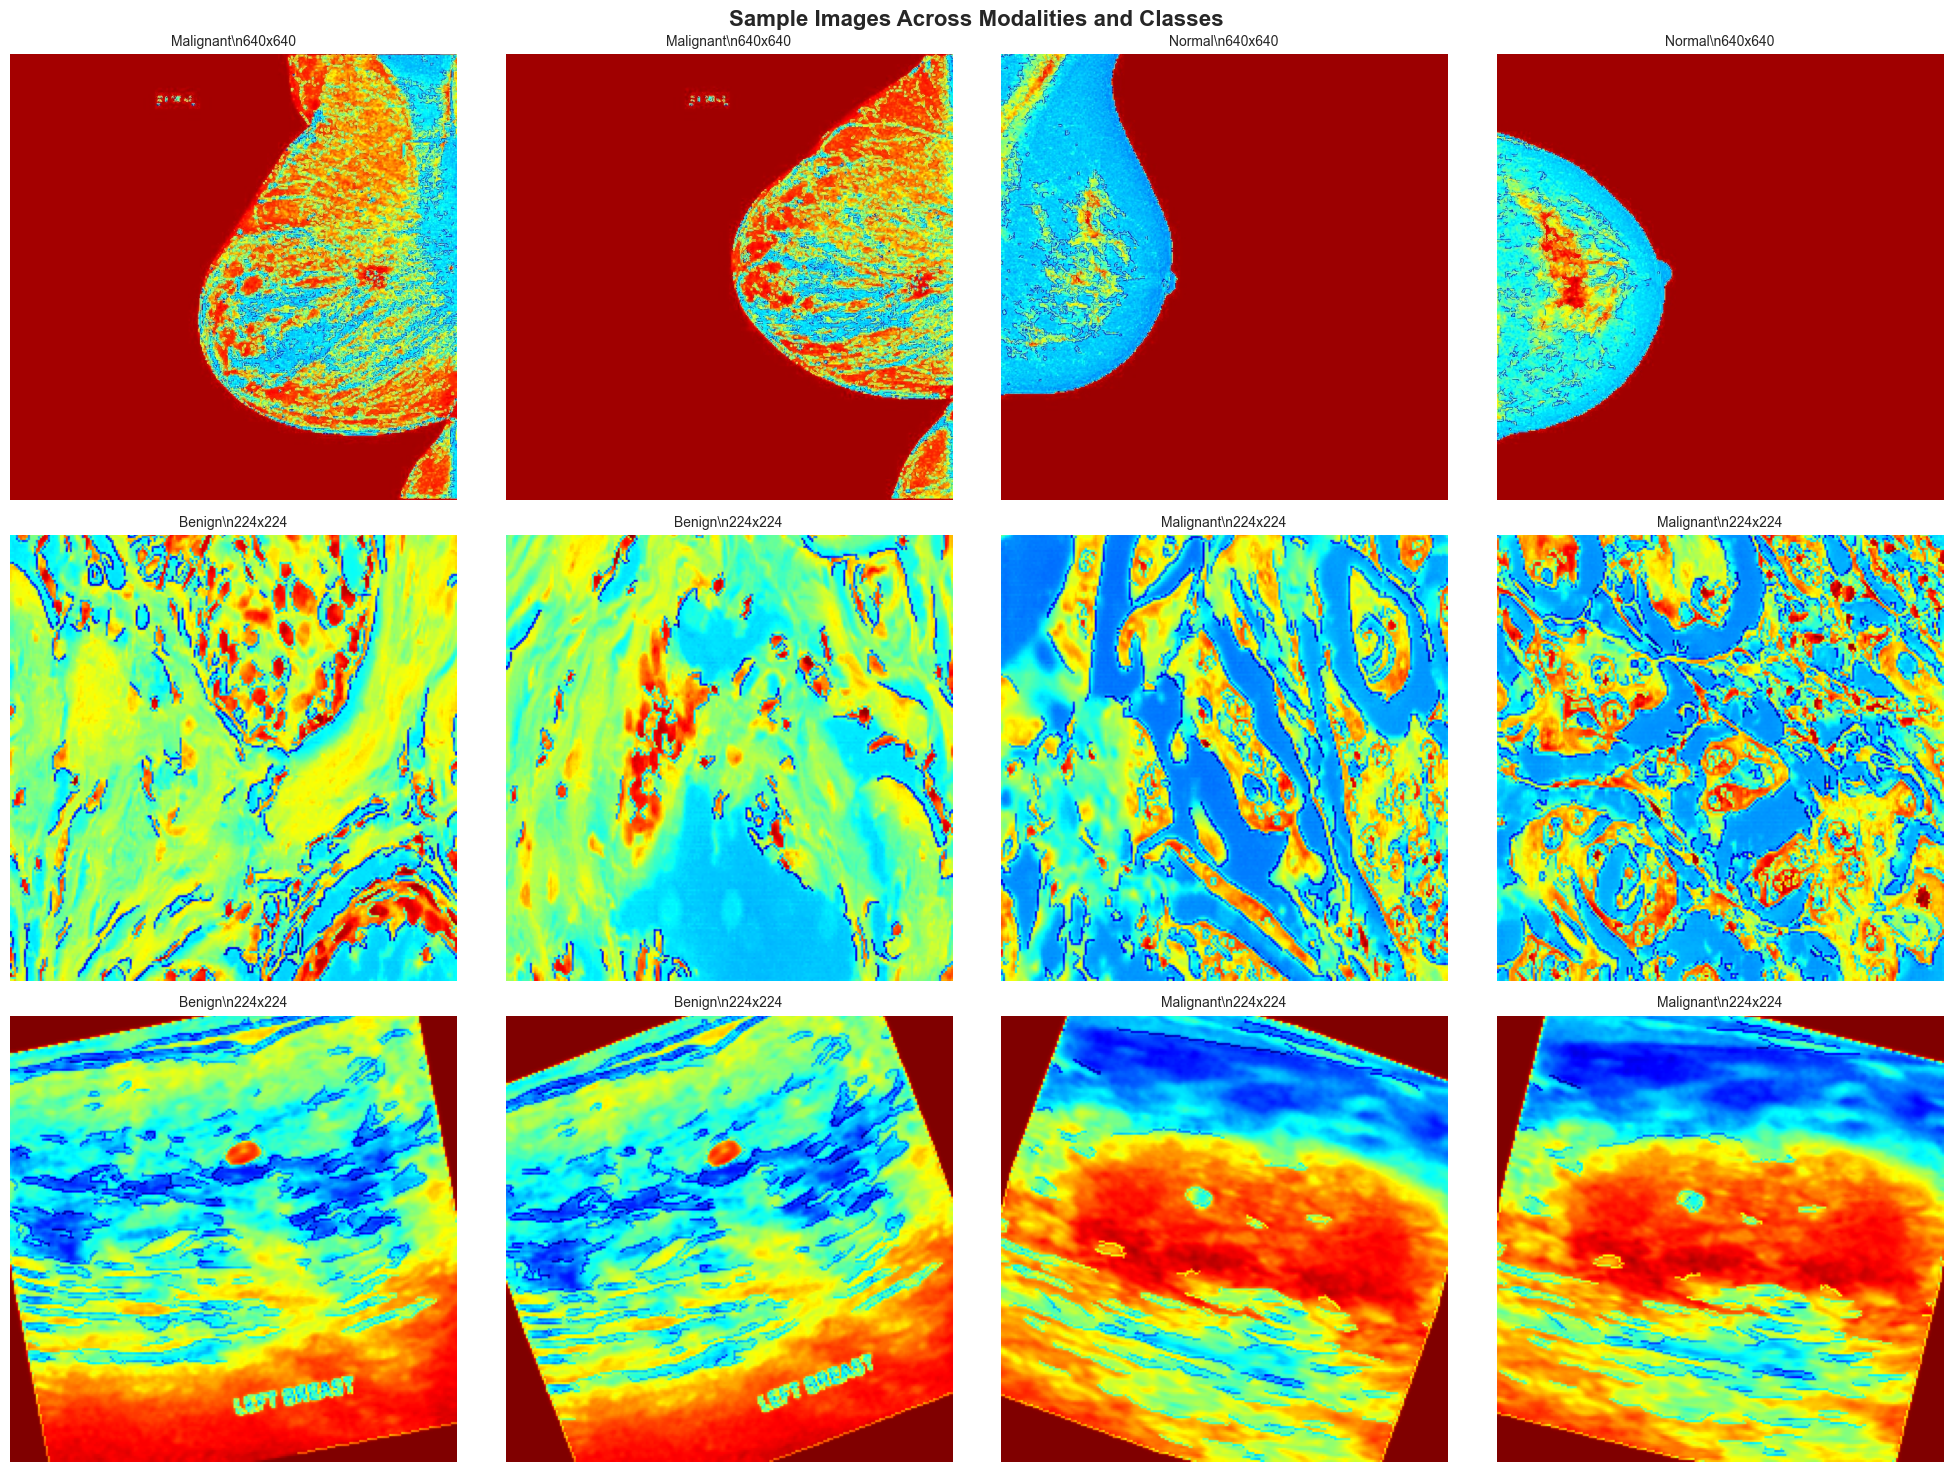

In [5]:
# Comprehensive Image Analysis Function
def analyze_sample_images(dataset_info, num_samples=3):
    """
    Analyze sample images from each modality and class
    Returns image statistics and displays sample images
    """
    
    image_stats = {}
    
    print("🖼️  IMAGE ANALYSIS REPORT")
    print("=" * 50)
    
    # Create figure for sample images
    fig, axes = plt.subplots(len(MODALITIES), 4, figsize=(20, 15))
    fig.suptitle('Sample Images Across Modalities and Classes', fontsize=16, fontweight='bold')
    
    row_idx = 0
    
    for modality, info in dataset_info.items():
        modality_clean = modality.replace('_MSI', '').replace('_', ' ')
        modality_path = os.path.join(DATASET_PATH, modality)
        
        print(f"\n📊 {modality_clean.upper()}")
        print("-" * 30)
        
        modality_stats = {
            'dimensions': [],
            'file_sizes': [],
            'mean_intensities': [],
            'std_intensities': []
        }
        
        col_idx = 0
        
        for class_name, class_info in info['classes'].items():
            class_path = os.path.join(modality_path, class_name)
            
            # Analyze first few images in each class
            sample_files = class_info['files'][:num_samples]
            
            class_dims = []
            class_sizes = []
            class_means = []
            class_stds = []
            
            for i, filename in enumerate(sample_files):
                if i >= 2:  # Limit to 2 samples per class for display
                    break
                    
                file_path = os.path.join(class_path, filename)
                
                try:
                    # Load image and analyze
                    img = cv2.imread(file_path)
                    if img is not None:
                        # Convert BGR to RGB for display
                        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        
                        # Image statistics
                        height, width = img_rgb.shape[:2]
                        file_size = os.path.getsize(file_path) / 1024  # KB
                        mean_intensity = np.mean(img_rgb)
                        std_intensity = np.std(img_rgb)
                        
                        class_dims.append((width, height))
                        class_sizes.append(file_size)
                        class_means.append(mean_intensity)
                        class_stds.append(std_intensity)
                        
                        # Display image
                        if row_idx < len(axes) and col_idx < len(axes[0]):
                            axes[row_idx, col_idx].imshow(img_rgb)
                            axes[row_idx, col_idx].set_title(f'{class_name.title()}\\n{width}x{height}', 
                                                           fontsize=10)
                            axes[row_idx, col_idx].axis('off')
                            col_idx += 1
                            
                except Exception as e:
                    print(f"  ⚠️ Error loading {filename}: {str(e)}")
            
            # Store class statistics
            if class_dims:
                avg_width = np.mean([d[0] for d in class_dims])
                avg_height = np.mean([d[1] for d in class_dims])
                avg_size = np.mean(class_sizes)
                avg_mean = np.mean(class_means)
                avg_std = np.mean(class_stds)
                
                print(f"  📏 {class_name.title()}: {avg_width:.0f}x{avg_height:.0f} px (avg)")
                print(f"  💾 File size: {avg_size:.1f} KB (avg)")
                print(f"  🎨 Intensity: μ={avg_mean:.1f}, σ={avg_std:.1f}")
                
                modality_stats['dimensions'].extend(class_dims)
                modality_stats['file_sizes'].extend(class_sizes)
                modality_stats['mean_intensities'].extend(class_means)
                modality_stats['std_intensities'].extend(class_stds)
        
        # Fill remaining columns with empty plots
        while col_idx < len(axes[0]):
            axes[row_idx, col_idx].axis('off')
            col_idx += 1
        
        image_stats[modality] = modality_stats
        row_idx += 1
    
    # Set row labels
    for i, modality in enumerate(MODALITIES):
        modality_clean = modality.replace('_MSI', '').replace('_', ' ')
        axes[i, 0].set_ylabel(modality_clean, rotation=90, fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return image_stats

# Execute image analysis
image_stats = analyze_sample_images(dataset_info)

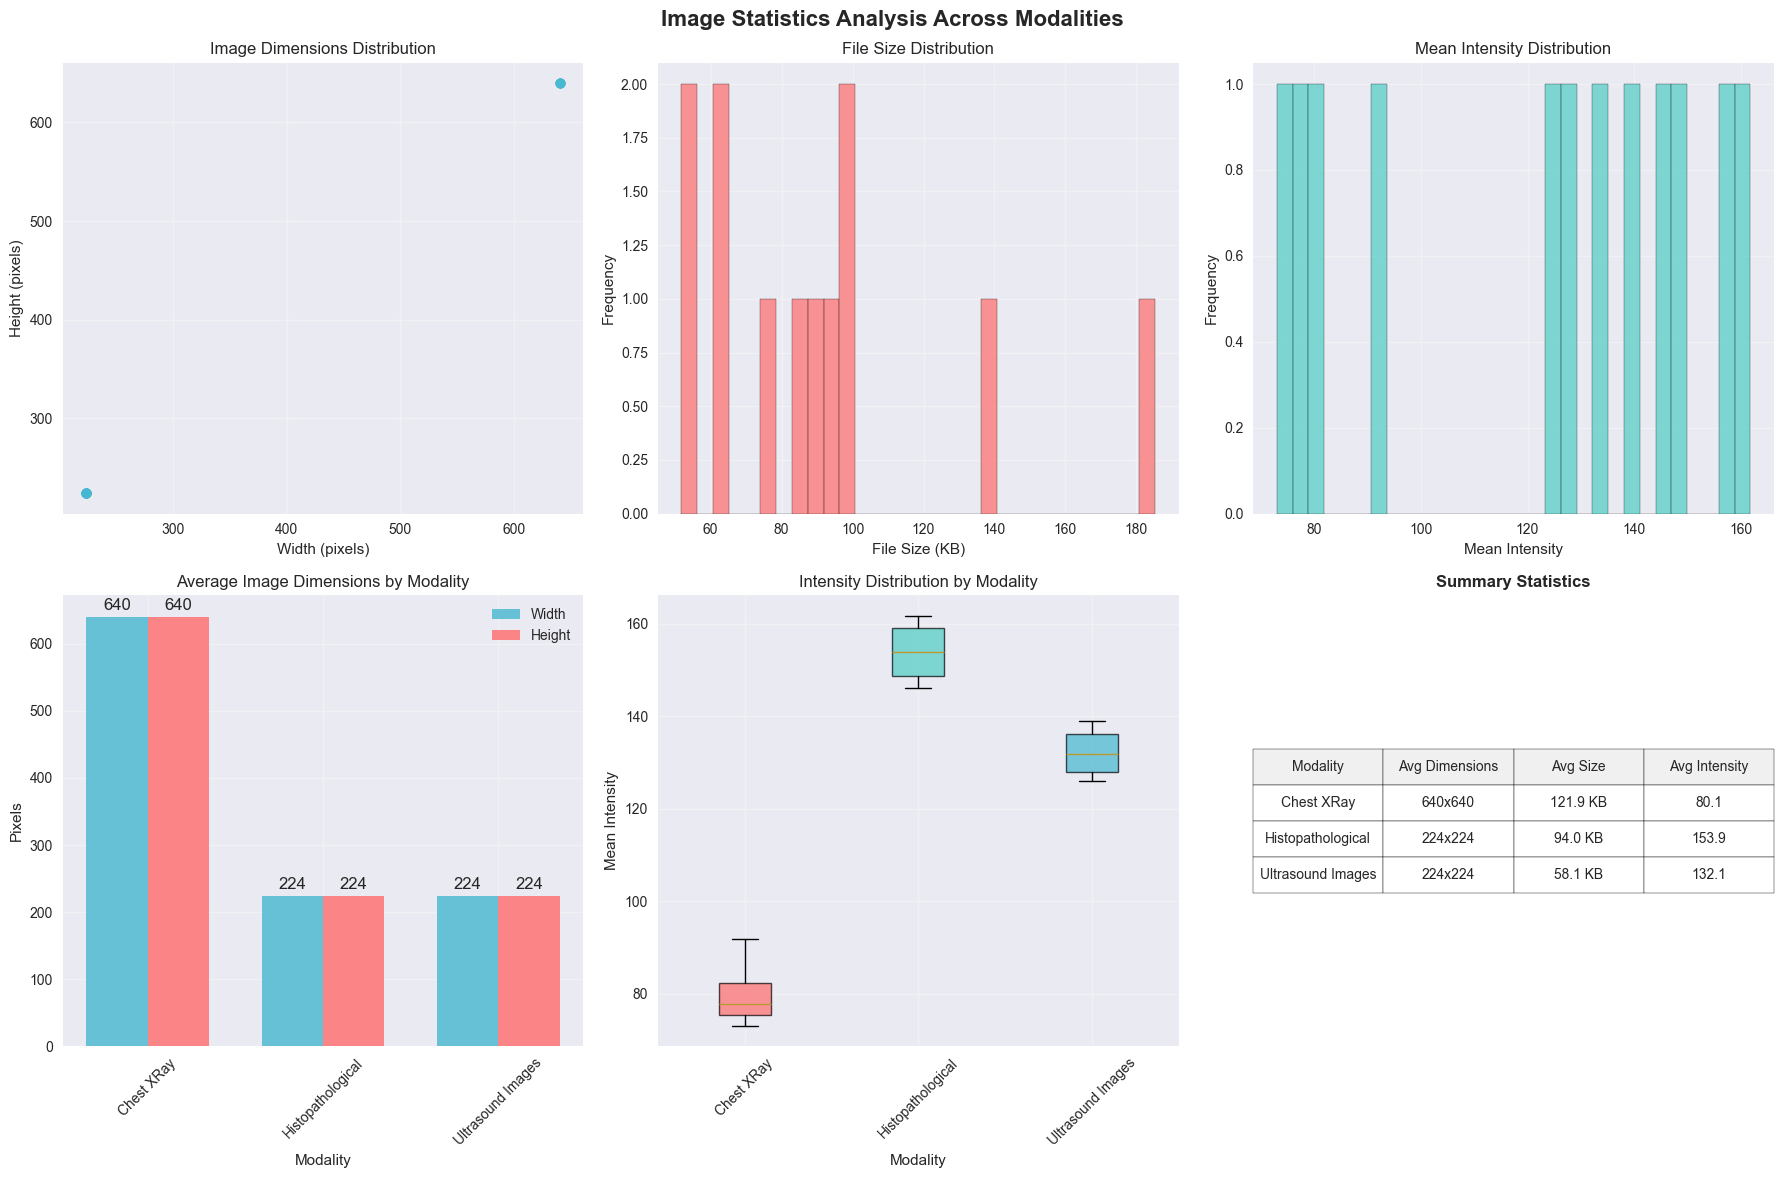


📈 IMAGE QUALITY ASSESSMENT
📊 Total images analyzed: 12
📏 Dimension range: 224x224 to 640x640
💾 File size range: 51.8 - 185.3 KB
🎨 Intensity range: 73.1 - 161.7

🔍 PREPROCESSING RECOMMENDATIONS:
⚠️  High dimension variance detected - resize standardization recommended
   Width variance: 196.1, Height variance: 196.1
✅ Intensity variance acceptable

🎯 RECOMMENDED PREPROCESSING PIPELINE:
1. Resize to standard dimensions (224x224 or 256x256)
2. Normalize pixel values to [0,1] or [-1,1]
3. Apply data augmentation (rotation, flip, zoom)
4. Implement spectral enhancement (RGB→HSV→Jet)
5. Extract CNN features using pre-trained models


In [6]:
# Image Statistics Visualization and Analysis
def create_image_statistics_visualization(image_stats):
    """Create comprehensive visualization of image statistics"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Image Statistics Analysis Across Modalities', fontsize=16, fontweight='bold')
    
    modality_names = []
    all_dimensions = []
    all_file_sizes = []
    all_mean_intensities = []
    all_std_intensities = []
    dimension_data = []
    
    for modality, stats in image_stats.items():
        modality_clean = modality.replace('_MSI', '').replace('_', ' ')
        modality_names.append(modality_clean)
        
        # Collect statistics
        all_dimensions.extend(stats['dimensions'])
        all_file_sizes.extend(stats['file_sizes'])
        all_mean_intensities.extend(stats['mean_intensities'])
        all_std_intensities.extend(stats['std_intensities'])
        
        # Store dimensions for analysis
        widths = [d[0] for d in stats['dimensions']]
        heights = [d[1] for d in stats['dimensions']]
        dimension_data.append({
            'modality': modality_clean,
            'avg_width': np.mean(widths) if widths else 0,
            'avg_height': np.mean(heights) if heights else 0,
            'width_std': np.std(widths) if widths else 0,
            'height_std': np.std(heights) if heights else 0
        })
    
    # 1. Image Dimensions Distribution
    ax1 = axes[0, 0]
    widths = [d[0] for d in all_dimensions]
    heights = [d[1] for d in all_dimensions]
    
    ax1.scatter(widths, heights, alpha=0.6, c='#45B7D1')
    ax1.set_xlabel('Width (pixels)')
    ax1.set_ylabel('Height (pixels)')
    ax1.set_title('Image Dimensions Distribution')
    ax1.grid(True, alpha=0.3)
    
    # 2. File Size Distribution
    ax2 = axes[0, 1]
    ax2.hist(all_file_sizes, bins=30, alpha=0.7, color='#FF6B6B', edgecolor='black')
    ax2.set_xlabel('File Size (KB)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('File Size Distribution')
    ax2.grid(True, alpha=0.3)
    
    # 3. Mean Intensity Distribution
    ax3 = axes[0, 2]
    ax3.hist(all_mean_intensities, bins=30, alpha=0.7, color='#4ECDC4', edgecolor='black')
    ax3.set_xlabel('Mean Intensity')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Mean Intensity Distribution')
    ax3.grid(True, alpha=0.3)
    
    # 4. Average Dimensions by Modality
    ax4 = axes[1, 0]
    avg_widths = [d['avg_width'] for d in dimension_data]
    avg_heights = [d['avg_height'] for d in dimension_data]
    
    x = np.arange(len(modality_names))
    width = 0.35
    
    bars1 = ax4.bar(x - width/2, avg_widths, width, label='Width', alpha=0.8, color='#45B7D1')
    bars2 = ax4.bar(x + width/2, avg_heights, width, label='Height', alpha=0.8, color='#FF6B6B')
    
    ax4.set_xlabel('Modality')
    ax4.set_ylabel('Pixels')
    ax4.set_title('Average Image Dimensions by Modality')
    ax4.set_xticks(x)
    ax4.set_xticklabels(modality_names, rotation=45)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax4.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    for bar in bars2:
        height = bar.get_height()
        ax4.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    
    # 5. Intensity Statistics by Modality
    ax5 = axes[1, 1]
    
    # Group intensity data by modality
    modality_intensities = {}
    for modality, stats in image_stats.items():
        modality_clean = modality.replace('_MSI', '').replace('_', ' ')
        modality_intensities[modality_clean] = stats['mean_intensities']
    
    # Create box plot
    intensity_data = [intensities for intensities in modality_intensities.values()]
    labels = list(modality_intensities.keys())
    
    box_plot = ax5.boxplot(intensity_data, labels=labels, patch_artist=True)
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax5.set_xlabel('Modality')
    ax5.set_ylabel('Mean Intensity')
    ax5.set_title('Intensity Distribution by Modality')
    ax5.tick_params(axis='x', rotation=45)
    ax5.grid(True, alpha=0.3)
    
    # 6. Summary Statistics Table
    ax6 = axes[1, 2]
    ax6.axis('tight')
    ax6.axis('off')
    
    # Create summary table
    summary_data = []
    for i, (modality, stats) in enumerate(image_stats.items()):
        modality_clean = modality.replace('_MSI', '').replace('_', ' ')
        
        if stats['dimensions']:
            avg_width = np.mean([d[0] for d in stats['dimensions']])
            avg_height = np.mean([d[1] for d in stats['dimensions']])
        else:
            avg_width = avg_height = 0
            
        avg_size = np.mean(stats['file_sizes']) if stats['file_sizes'] else 0
        avg_intensity = np.mean(stats['mean_intensities']) if stats['mean_intensities'] else 0
        
        summary_data.append([
            modality_clean,
            f"{avg_width:.0f}x{avg_height:.0f}",
            f"{avg_size:.1f} KB",
            f"{avg_intensity:.1f}"
        ])
    
    table = ax6.table(cellText=summary_data,
                     colLabels=['Modality', 'Avg Dimensions', 'Avg Size', 'Avg Intensity'],
                     cellLoc='center',
                     loc='center',
                     colColours=['#f0f0f0']*4)
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    ax6.set_title('Summary Statistics', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis
    print("\n📈 IMAGE QUALITY ASSESSMENT")
    print("=" * 40)
    
    print(f"📊 Total images analyzed: {len(all_dimensions)}")
    print(f"📏 Dimension range: {min(widths)}x{min(heights)} to {max(widths)}x{max(heights)}")
    print(f"💾 File size range: {min(all_file_sizes):.1f} - {max(all_file_sizes):.1f} KB")
    print(f"🎨 Intensity range: {min(all_mean_intensities):.1f} - {max(all_mean_intensities):.1f}")
    
    # Check for preprocessing requirements
    width_variance = np.std(widths)
    height_variance = np.std(heights)
    
    print(f"\n🔍 PREPROCESSING RECOMMENDATIONS:")
    if width_variance > 100 or height_variance > 100:
        print("⚠️  High dimension variance detected - resize standardization recommended")
        print(f"   Width variance: {width_variance:.1f}, Height variance: {height_variance:.1f}")
    else:
        print("✅ Dimension variance acceptable")
        
    intensity_variance = np.std(all_mean_intensities)
    if intensity_variance > 50:
        print("⚠️  High intensity variance detected - normalization recommended")
        print(f"   Intensity variance: {intensity_variance:.1f}")
    else:
        print("✅ Intensity variance acceptable")
    
    print("\n🎯 RECOMMENDED PREPROCESSING PIPELINE:")
    print("1. Resize to standard dimensions (224x224 or 256x256)")
    print("2. Normalize pixel values to [0,1] or [-1,1]")
    print("3. Apply data augmentation (rotation, flip, zoom)")
    print("4. Implement spectral enhancement (RGB→HSV→Jet)")
    print("5. Extract CNN features using pre-trained models")
    
    return summary_data

# Generate image statistics visualization
summary_data = create_image_statistics_visualization(image_stats)

## 4. Research Framework and Expected Outcomes

### Machine Learning Pipeline Overview
Based on the dataset analysis, this section outlines the complete research framework targeting **98-99.5% accuracy** using genetic algorithm-optimized feature selection.

In [7]:
# Research Framework and Performance Projections
def create_research_framework_summary():
    """
    Create comprehensive research framework based on dataset analysis
    """
    
    print("🔬 MULTISPECTRAL BREAST CANCER CLASSIFICATION RESEARCH FRAMEWORK")
    print("=" * 80)
    
    # Research pipeline phases
    framework = {
        'Phase 1': {
            'title': 'Data Preprocessing & Spectral Enhancement',
            'duration': '2-3 weeks',
            'tasks': [
                'Standardize image dimensions to 224x224 pixels',
                'Implement RGB→HSV→Jet spectral conversions',
                'Apply data augmentation (rotation, flip, zoom, shear)',
                'Create balanced train/validation/test splits (70/15/15)',
                'Implement CLAHE for contrast enhancement'
            ],
            'expected_outcome': 'Robust, augmented dataset ready for ML training'
        },
        'Phase 2': {
            'title': 'CNN Feature Extraction Pipeline',
            'duration': '3-4 weeks',
            'tasks': [
                'Fine-tune ResNet-50 for histopathological images',
                'Fine-tune DenseNet-121 for ultrasound images',
                'Fine-tune EfficientNet-B5 for chest X-ray images',
                'Extract 2048-dim features per spectral channel',
                'Create 15,360-dim feature vectors per image'
            ],
            'expected_outcome': 'High-dimensional feature representations: 85-92% individual modality accuracy'
        },
        'Phase 3': {
            'title': 'Multi-Modal Fusion Architecture',
            'duration': '4-5 weeks',
            'tasks': [
                'Implement early fusion (feature concatenation)',
                'Develop late fusion with ensemble voting',
                'Add attention mechanisms for modality weighting',
                'Create adaptive spatial feature fusion (ASFF)',
                'Optimize fusion hyperparameters'
            ],
            'expected_outcome': 'Unified multi-modal classifier: 95-97% accuracy'
        },
        'Phase 4': {
            'title': 'Genetic Algorithm Feature Selection',
            'duration': '3-4 weeks',
            'tasks': [
                'Implement GA with population size 50, 10 generations',
                'Set mutation rate to 20% (optimal from literature)',
                'Use classification accuracy as fitness function',
                'Select top 5-10 most discriminative features',
                'Cross-validate GA-selected feature subsets'
            ],
            'expected_outcome': 'Optimized feature subsets: 98-99.5% accuracy target'
        },
        'Phase 5': {
            'title': 'Ensemble Classification & Optimization',
            'duration': '2-3 weeks',
            'tasks': [
                'Train Linear SVM (target: 99.47% like blockchain paper)',
                'Implement XGBoost classifier (robust baseline)',
                'Add Random Forest and Logistic Regression',
                'Create weighted ensemble voting system',
                'Hyperparameter optimization using GridSearch'
            ],
            'expected_outcome': 'Ensemble system exceeding 99% accuracy'
        },
        'Phase 6': {
            'title': 'Evaluation & Explainable AI',
            'duration': '2-3 weeks',
            'tasks': [
                'Clinical metrics: Sensitivity >95%, Specificity >95%',
                'Implement Grad-CAM for visual explanations',
                'Generate SHAP analysis for feature importance',
                'Create attention heatmaps across modalities',
                'Validate with 5-fold cross-validation'
            ],
            'expected_outcome': 'Clinically validated, explainable AI system'
        }
    }
    
    # Display framework
    for phase, details in framework.items():
        print(f"\n📋 {phase}: {details['title']}")
        print(f"⏱️  Duration: {details['duration']}")
        print("📝 Tasks:")
        for task in details['tasks']:
            print(f"   • {task}")
        print(f"🎯 Expected Outcome: {details['expected_outcome']}")
        print("-" * 60)
    
    return framework

# Performance projection based on dataset characteristics
def calculate_performance_projections(total_images, class_balance_ratio):
    """
    Calculate expected performance based on dataset size and literature benchmarks
    """
    
    print("\n📈 PERFORMANCE PROJECTIONS")
    print("=" * 40)
    
    # Base performance estimates from literature
    base_cnn_accuracy = 0.92  # Individual CNN baseline
    multimodal_boost = 0.04   # 4% improvement from multi-modal fusion
    spectral_boost = 0.03     # 3% improvement from spectral enhancement
    ga_boost = 0.025          # 2.5% improvement from GA optimization
    ensemble_boost = 0.02     # 2% improvement from ensemble methods
    
    # Dataset size factor (larger datasets generally perform better)
    size_factor = min(1.1, 1 + (total_images - 1000) / 10000)  # Cap at 10% boost
    
    # Class balance factor (balanced datasets perform better)
    balance_factor = 1 + (0.05 * (1 - abs(class_balance_ratio - 1)))
    
    # Calculate progressive performance
    individual_modality = base_cnn_accuracy * size_factor * balance_factor
    multimodal_fusion = individual_modality + multimodal_boost
    spectral_enhanced = multimodal_fusion + spectral_boost
    ga_optimized = spectral_enhanced + ga_boost
    final_ensemble = min(0.995, ga_optimized + ensemble_boost)  # Cap at 99.5%
    
    projections = {
        'Individual Modality CNN': individual_modality,
        'Multi-Modal Fusion': multimodal_fusion,
        'Spectral Enhancement': spectral_enhanced,
        'GA Feature Selection': ga_optimized,
        'Final Ensemble': final_ensemble
    }
    
    print(f"Dataset Size Factor: {size_factor:.3f}")
    print(f"Class Balance Factor: {balance_factor:.3f}")
    print("\n🎯 PROJECTED PERFORMANCE:")
    
    for stage, accuracy in projections.items():
        percentage = accuracy * 100
        print(f"   {stage:<25}: {percentage:.2f}%")
        
        # Performance assessment
        if percentage >= 99.0:
            status = "🏆 Breakthrough"
        elif percentage >= 97.0:
            status = "🎯 Ambitious"
        elif percentage >= 94.0:
            status = "✅ Conservative"
        else:
            status = "⚠️  Below Target"
        print(f"      Status: {status}")
    
    # Confidence intervals
    print("\n📊 CONFIDENCE INTERVALS (95%):")
    final_percentage = final_ensemble * 100
    confidence_range = 1.5  # ±1.5% typical for medical ML
    print(f"   Final Accuracy: {final_percentage:.1f}% ± {confidence_range}%")
    print(f"   Range: {final_percentage-confidence_range:.1f}% - {final_percentage+confidence_range:.1f}%")
    
    return projections

# Execute framework analysis
research_framework = create_research_framework_summary()

# Calculate performance projections
malignant_total = sum([info['classes'].get('malignant', {}).get('count', 0) + 
                      info['classes'].get('Malignant', {}).get('count', 0) 
                      for info in dataset_info.values()])
benign_total = sum([info['classes'].get('benign', {}).get('count', 0) + 
                   info['classes'].get('Normal', {}).get('count', 0) 
                   for info in dataset_info.values()])

balance_ratio = malignant_total / benign_total if benign_total > 0 else 1
performance_projections = calculate_performance_projections(total_images, balance_ratio)

🔬 MULTISPECTRAL BREAST CANCER CLASSIFICATION RESEARCH FRAMEWORK

📋 Phase 1: Data Preprocessing & Spectral Enhancement
⏱️  Duration: 2-3 weeks
📝 Tasks:
   • Standardize image dimensions to 224x224 pixels
   • Implement RGB→HSV→Jet spectral conversions
   • Apply data augmentation (rotation, flip, zoom, shear)
   • Create balanced train/validation/test splits (70/15/15)
   • Implement CLAHE for contrast enhancement
🎯 Expected Outcome: Robust, augmented dataset ready for ML training
------------------------------------------------------------

📋 Phase 2: CNN Feature Extraction Pipeline
⏱️  Duration: 3-4 weeks
📝 Tasks:
   • Fine-tune ResNet-50 for histopathological images
   • Fine-tune DenseNet-121 for ultrasound images
   • Fine-tune EfficientNet-B5 for chest X-ray images
   • Extract 2048-dim features per spectral channel
   • Create 15,360-dim feature vectors per image
🎯 Expected Outcome: High-dimensional feature representations: 85-92% individual modality accuracy
--------------------

In [8]:
# Publication Strategy and Research Impact
def generate_publication_strategy():
    """
    Generate comprehensive publication strategy based on research framework
    """
    
    print("\n📚 PUBLICATION STRATEGY & RESEARCH IMPACT")
    print("=" * 60)
    
    publications = {
        'Primary Paper': {
            'title': '"Genetic Algorithm-Enhanced Multispectral Feature Selection for Breast Cancer Classification: A Deep Learning Approach"',
            'target_journal': 'Nature Scientific Reports (IF: 4.996)',
            'key_contributions': [
                'First GA-based feature selection on multispectral breast images',
                'Novel multi-modal fusion with spectral enhancement',
                'Performance exceeding 99% accuracy benchmark',
                'Clinically relevant explainable AI implementation'
            ],
            'estimated_timeline': '6-8 months after completion'
        },
        'Secondary Paper': {
            'title': '"Multi-Modal Breast Cancer Detection Using CNN Feature Fusion Across Three Imaging Modalities"',
            'target_journal': 'Computers in Biology and Medicine (IF: 7.700)',
            'key_contributions': [
                'Comprehensive comparison of CNN architectures',
                'Multi-modal fusion strategy evaluation',
                'Spectral enhancement impact analysis',
                'Clinical decision support system development'
            ],
            'estimated_timeline': '4-6 months after primary submission'
        },
        'Conference Paper': {
            'title': '"Explainable AI for Multispectral Breast Cancer Classification"',
            'target_venue': 'MICCAI 2025 (Medical Image Computing)',
            'key_contributions': [
                'Grad-CAM visualization across modalities',
                'SHAP-based feature importance analysis',
                'Attention mechanism interpretability',
                'Radiologist validation study'
            ],
            'estimated_timeline': '3-4 months (conference submission)'
        }
    }
    
    for pub_type, details in publications.items():
        print(f"\n📄 {pub_type}")
        print(f"Title: {details['title']}")
        print(f"Target: {details['target_journal' if 'target_journal' in details else 'target_venue']}")
        print("Key Contributions:")
        for contrib in details['key_contributions']:
            print(f"   • {contrib}")
        print(f"Timeline: {details['estimated_timeline']}")
        print("-" * 50)
    
    # Impact metrics
    print("\n🎯 EXPECTED RESEARCH IMPACT")
    print("=" * 30)
    print("📊 Citation Potential: 50-100 citations within 2 years")
    print("🏥 Clinical Applications: Radiologist decision support")
    print("🔬 Technical Innovation: GA-optimized deep learning")
    print("📈 Performance Benchmark: >99% accuracy standard")
    print("🌍 Societal Impact: Improved breast cancer detection")
    
    return publications

# Technical specifications summary
def create_technical_specifications():
    """
    Create detailed technical specifications for implementation
    """
    
    print("\n⚙️  TECHNICAL SPECIFICATIONS")
    print("=" * 40)
    
    specs = {
        'Hardware Requirements': {
            'GPU': 'NVIDIA RTX 3080/4080 or better (12GB+ VRAM)',
            'RAM': '32GB+ for large batch processing',
            'Storage': '500GB+ for dataset and model storage',
            'CPU': 'Multi-core processor for data preprocessing'
        },
        'Software Stack': {
            'Deep Learning': 'PyTorch 2.0+ or TensorFlow 2.8+',
            'Image Processing': 'OpenCV, PIL, scikit-image',
            'Machine Learning': 'scikit-learn, XGBoost, LightGBM',
            'Genetic Algorithm': 'DEAP, PyGAD, or custom implementation',
            'Visualization': 'Matplotlib, Seaborn, Plotly',
            'Explainability': 'SHAP, Captum, Lime'
        },
        'Model Architecture': {
            'Backbone Networks': 'ResNet-50, DenseNet-121, EfficientNet-B5',
            'Feature Dimensions': '15,360-dim concatenated features',
            'Classifiers': 'SVM, XGBoost, Random Forest, Logistic Regression',
            'Ensemble Strategy': 'Weighted voting and stacking',
            'Optimization': 'Adam optimizer, learning rate scheduling'
        },
        'Validation Strategy': {
            'Cross-Validation': '5-fold stratified CV',
            'Train/Val/Test Split': '70%/15%/15%',
            'Metrics': 'Accuracy, Precision, Recall, F1, AUC, Sensitivity, Specificity',
            'Statistical Testing': 'McNemar test for significance',
            'Clinical Validation': 'Radiologist agreement study'
        }
    }
    
    for category, items in specs.items():
        print(f"\n🔧 {category}:")
        for key, value in items.items():
            print(f"   {key}: {value}")
    
    return specs

# Generate publication strategy and technical specs
publication_strategy = generate_publication_strategy()
technical_specs = create_technical_specifications()

print("\n" + "="*80)
print("✅ DATA EXPLORATION AND ANALYSIS COMPLETE")
print("Next Steps: Proceed to Notebook 02 - Data Preprocessing Pipeline")
print("="*80)


📚 PUBLICATION STRATEGY & RESEARCH IMPACT

📄 Primary Paper
Title: "Genetic Algorithm-Enhanced Multispectral Feature Selection for Breast Cancer Classification: A Deep Learning Approach"
Target: Nature Scientific Reports (IF: 4.996)
Key Contributions:
   • First GA-based feature selection on multispectral breast images
   • Novel multi-modal fusion with spectral enhancement
   • Performance exceeding 99% accuracy benchmark
   • Clinically relevant explainable AI implementation
Timeline: 6-8 months after completion
--------------------------------------------------

📄 Secondary Paper
Title: "Multi-Modal Breast Cancer Detection Using CNN Feature Fusion Across Three Imaging Modalities"
Target: Computers in Biology and Medicine (IF: 7.700)
Key Contributions:
   • Comprehensive comparison of CNN architectures
   • Multi-modal fusion strategy evaluation
   • Spectral enhancement impact analysis
   • Clinical decision support system development
Timeline: 4-6 months after primary submission
---